In [14]:
import numpy as np
import pandas as pd
import random
import os
import subprocess

from sklearn.cross_validation import train_test_split
from sklearn import preprocessing, linear_model, metrics, grid_search, tree

import matplotlib.pylab as plt
%matplotlib inline

SEED = 32

np.random.seed(SEED)
random.seed(SEED)

In [15]:
data_path = '/nfs/science-tuk-ins/tesco_insurance/adamho/AppliedMLTraining/data/'

## Excercise 6: Interactions and Decision Trees

So far in our lab excercises, we have spent a lot of time talking about linear models. Linear models assume that our features $X$ have a linear relationship with our target $y$. We know that by taking monotonic transformations of our features (e.g. $x^3$), we can identify nonlinear relationships. In particular, L1 Regularised Regression can be used to select useful transformations that play well a linear model.

Nonlinear transformations are great, but there are other import things that we must consider before using them...

Crucially, it's possible for variables to interact in complex ways. For example, a customer's propensity to buy soup when it's rainy may depend on whether she had soup yesterday; here, soup sales depend on the interaction between the weather and a customer's previous consumption. Thus - as well as testing transformations - we should arguably also be testing interactions in our linear models.

Let's try creating some interaction 'terms' in our data and validate what it does to our model performance.


In [16]:
# Like good programmers, we'll reuse our functions from the last lab session
def fill_missing(dataframe, value):
    """Fill missing values of a dataframe with value"""
    return dataframe.fillna(value)

def _determine_categoricals(dataset):
    """Return list of names for categorical columns in dataframe"""
    num_cols = train._get_numeric_data().columns
    return list(set(train.columns) - set(num_cols))
    
def create_dummy_variables(train, test):
    """Create dummmy variables for categorical columns in train and test (both must be dataframes)"""
    
    # Ensure that the columns are the same on both datasets
    assert(sum(train.columns == test.columns) == len(train.columns))
    
    # Temporarily combine the training and test sets
    full = pd.concat([train.reset_index(drop=True), test.reset_index(drop=True)], axis=0).reset_index(drop=True)
    
    # Determine the categorical columns
    cat_cols = _determine_categoricals(full)
    print('Dummies will be created for the following columns: {0:s}' .format(cat_cols))
    
    # Create dummy variables for those columns
    dummies_full = pd.get_dummies(full)

    # Return the full train and test sets with dummies inside
    train_wdummies = dummies_full.ix[0:train.shape[0]-1,:]
    test_wdummies = dummies_full.ix[train.shape[0]:dummies_full.shape[0],:]
    
    return train_wdummies, test_wdummies

def preprocess_data(train, test):
    """Preprocess a training and test set"""
    
    train = fill_missing(train, 0)
    test = fill_missing(test, 0)
    
    train, test = create_dummy_variables(train, test)
    
    return train, test

In [17]:
# We will just use data from this year (we're not trying to predict next year)
train = pd.read_csv(data_path + 'classification.csv') # This is the data from last month

# Separate out targets, features and ids
train_y = train['bought_pancakes'] # y variables
train_X = train.drop(['household', 'segmentation', 'bought_pancakes'], axis=1) # X features

# Create a training and two test sets
train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=0.7)
test_X, eval_X, test_y, eval_y = train_test_split(test_X, test_y, test_size=0.5)

# Preprocess the data
_, test_X = preprocess_data(train_X, test_X)
train_X, eval_X = preprocess_data(train_X, eval_X)

Dummies will be created for the following columns: ['lifestyle_high']
Dummies will be created for the following columns: ['lifestyle_high']


In [5]:
# As we're linear modelling, let's scale the data
scl = preprocessing.MinMaxScaler()
train_X_scl = scl.fit_transform(train_X)
test_X_scl = scl.transform(test_X)
eval_X_scl = scl.transform(eval_X)

In [6]:
train_X.head()

dollar_sales  units  coupon  unique_upc  unique_store  unique_basket  \
0          0.00    0.0     0.0         0.0           0.0            0.0   
1          8.95    5.0     0.0         5.0           1.0            5.0   
2         22.97   13.0     0.0        10.0           2.0            6.0   
3          0.00    0.0     0.0         0.0           0.0            0.0   
4          4.52    6.0     0.0         3.0           1.0            1.0   

   unique_brand  dollar_sales_pancake mixes  dollar_sales_pasta  \
0           0.0                        0.00                0.00   
1           2.0                        2.09                4.07   
2           6.0                        0.00                6.19   
3           0.0                        0.00                0.00   
4           1.0                        0.00                1.00   

   dollar_sales_pasta sauce        ...          units_pasta  \
0                      0.00        ...                  0.0   
1                      0.00        ...                  3.0   
2                     12.94        ...                  5.0   
3                      0.00        ...                  0.0   
4                      3.52        ...                  2.0   

   units_pasta sauce  units_syrups  coupon_pancake mixes  coupon_pasta  \
0                0.0           0.0                   0.0           0.0   
1                0.0           1.0                   0.0           0.0   
2                6.0           2.0                   0.0           0.0   
3                0.0           0.0                   0.0           0.0   
4                4.0           0.0                   0.0           0.0   

   coupon_pasta sauce  coupon_syrups  lifestyle_high_LA  lifestyle_high_MM  \
0                 0.0            0.0                1.0                0.0   
1                 0.0            0.0                0.0                0.0   
2                 0.0            0.0                1.0                0.0   
3                 0.0            0.0                0.0                1.0   
4                 0.0            0.0                0.0                0.0   

   lifestyle_high_UM  
0                0.0  
1                1.0  
2                0.0  
3                0.0  
4                1.0  

[5 rows x 22 columns]

So now that we've preprocessed and scaled our data, let's create some interactions. How? We can actually use our old friend ```PolynomialFeatures()``` from sklearn!

I must admit, I haven't been honest with you up until now. In addition to taking each variable to the power of a given degree (e.g. $x^3$ is $x$ raised to degree 3), the PolynomialFeatures() function also generates interactions between columns to a given degree (e.g. $x_i * x_j$ is an interaction of degree 2 because there are 2 columns).

In [7]:
degree = 3
poly = preprocessing.PolynomialFeatures(degree=degree, interaction_only=True, include_bias=False)
train_X_ints = poly.fit_transform(train_X)
test_X_ints = poly.transform(test_X)
eval_X_ints = poly.transform(eval_X)

In [8]:
print('The shape of your training set is now {0:s}') .format(train_X_ints.shape)

The shape of your training set is now (153008, 1793)


It may have taken some time, but we now have a matrix of all of our original columns and the interactions (up to degree 4) between all of those columns! Thus, after our original 22 features, we should now be able to find the interactions.

In fact, we can check that the 23rd column in our new matrix train_X_ints is the same as multiplying column 1 with column 2...

In [11]:
np.array_equal(train_X_ints[:,22], train_X.values[:,0] * train_X.values[:,1])

True

Great stuff! Let's stick that new matrix of data in to a LogisticRegression and see what happens to the performance of our model...

In [12]:
# Note that we are reducing our data size to a 5% sample (previously, we took a 10%)
_, train_X_smp, _, train_y_smp = train_test_split(train_X_ints, train_y, test_size=0.1)
print ('The shape of our training set is now {0:s} ') .format(train_X_smp.shape)

The shape of our training set is now (15301, 1793) 


In [13]:
# The models take a while, so I'll give you the optimal C value
parameters = {'C':[0.008], 'penalty' : ['l1']} # We'll use a high regularisation, as there are so many features.
mod = linear_model.LogisticRegression()
clf = grid_search.GridSearchCV(mod, parameters, cv=2, n_jobs=2, verbose=3)
clf.fit(train_X_smp, train_y_smp) # This performs a grid search across all listed values for C

# Now we can make predictions with the best model from the grid search
preds = clf.predict_proba(test_X_ints)[:, 1]

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] penalty=l1, C=0.008 .............................................
[CV] .................... penalty=l1, C=0.008, score=0.838452 - 1.4min
[CV] penalty=l1, C=0.008 .............................................
[CV] .................... penalty=l1, C=0.008, score=0.840392 - 2.1min


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:  3.5min finished


In [18]:
# Now let's evaluate our model
auc = metrics.roc_auc_score(test_y, preds)
logloss = metrics.log_loss(test_y, preds)

# We'll evaluate our model using Log Loss and AUC. If you want to know more about how AUC is calculated, you can go to this link:
# https://www.quora.com/Machine-Learning-What-is-an-intuitive-explanation-of-AUC
# An intuitive explanation is: 1.0 = perfect model, 0.5 = random guessing

print('The Log Loss for this model on the test set is {0:.2f} ') .format(logloss)
print('The AUC for this model on the test set is {0:.2f} ') .format(auc)
print('The best performing C value was {0:s}') .format(clf.best_params_ )

The Log Loss for this model on the test set is 0.46 
The AUC for this model on the test set is 0.65 
The best performing C value was {'penalty': 'l1', 'C': 0.008}


If you recall from our previous excercise, our log-loss and auc were around 0.4 and 0.66, respectively. Adding some interactions has not improved the log loss or the AUC. My hunch is that the huge cardinality of the dataset (i.e. 1159 features) has made it very difficult for L1 to find the solution. Whilst L1 is a poweful tool for feature selection, it can slow down considerably when you feed it lots of data (particularly columns).


## Excercise 6.2: Decision Trees

Doesn't it seem a bit 'brute force' to be testing all of these variables at once in an L1 regression? The models are taking ages to run and we haven't even tested non-linear transformations yet. Indeed, the only reason why we're testing them is because linear models make a lot of assumptions; we've been trying to make the 'hand' of our data fit the 'glove' that is linear modelling.

Thankfully there is a way to 'learn' interactions efficiently; Decision Trees. Descision tree algorithms learn by finding ways to split the data into groups. In the case of binary classification, trees find conditions in variables (e.g. if Ocset_Spend > 50) that best separate members of the positive class (i.e. 1s) from the negative class (i.e. 0s).

Let's try fitting a decision tree to our data. We'll look at the parameters that we need to tune and then visualise our final tree.

In [19]:
# We can use sklearn's DecisionTreeClassifier from the tree part of the library
clf = tree.DecisionTreeClassifier()
clf.fit(train_X, train_y)
preds = clf.predict_proba(test_X)[:, 1]
train_preds = clf.predict_proba(train_X)[:, 1]

In [20]:
# Now let's evaluate our model
auc = metrics.roc_auc_score(test_y, preds)
logloss = metrics.log_loss(test_y, preds)

train_auc = metrics.roc_auc_score(train_y, train_preds)
train_logloss = metrics.log_loss(train_y, train_preds)

print('Training Set Performance')
print('The Log Loss for this model on the training set is {0:.2f} ') .format(train_logloss)
print('The AUC for this model on the training set is {0:.2f} ') .format(train_auc)
print('')
print('Test Set Performance')
print('The Log Loss for this model on the test set is {0:.2f} ') .format(logloss)
print('The AUC for this model on the test set is {0:.2f} ') .format(auc)

Training Set Performance
The Log Loss for this model on the training set is 0.17 
The AUC for this model on the training set is 0.93 

Test Set Performance
The Log Loss for this model on the test set is 5.32 
The AUC for this model on the test set is 0.55 


Great, we've fit our first DecisionTreeClassifier! That was easy.

We can see from the test set that the AUC and LogLoss is nowhere near as good as the Logistic Regression.

##### Q1: Take a look at the the probabilities output from the model (either preds or train_preds). What do you notice about these 'probabilities'? Does this explain why the log-loss on the test set is so high?

Once you're done answering Q1, take a look at the following link to find out why this is happening: https://github.com/scikit-learn/scikit-learn/issues/1460

##### Q2: Take a look at the training set performance. Our model seems to have overfit pretty badly. Can you explain why? (HINT: Take a look at what happens when we don't specify a 'max_depth' for the DecisionTreeClassifier in the sklearn documentation: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)


Clearly we need to try and tune some hyper-parameters of our decision tree. Let's have a go at that now and see what happens to the performance of our model on the training and test set...

In [21]:
# The models take a while, so I'll give you the optimal C value
parameters = {
    'max_features' : [0.7, 0.8,0.9],
    'max_depth' : [12,15,19]
    
} # The 'C' parameter is 1 - regularisation lambda
mod = tree.DecisionTreeClassifier(random_state=32)
clf = grid_search.GridSearchCV(mod, parameters, cv=2, n_jobs=1, verbose=3, scoring='roc_auc')
clf.fit(train_X, train_y) # This performs a grid search across all listed values for C

# Now we can make predictions with the best model from the grid search
preds = clf.predict_proba(test_X)[:, 1]
train_preds = clf.predict_proba(train_X)[:, 1]

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] max_features=0.7, max_depth=12 ..................................
[CV] ......... max_features=0.7, max_depth=12, score=0.644888 -   0.4s
[CV] max_features=0.7, max_depth=12 ..................................
[CV] ......... max_features=0.7, max_depth=12, score=0.645576 -   0.4s
[CV] max_features=0.8, max_depth=12 ..................................
[CV] ......... max_features=0.8, max_depth=12, score=0.649004 -   0.3s
[CV] max_features=0.8, max_depth=12 ..................................
[CV] ......... max_features=0.8, max_depth=12, score=0.646677 -   0.3s
[CV] max_features=0.9, max_depth=12 ..................................
[CV] ......... max_features=0.9, max_depth=12, score=0.646204 -   0.3s
[CV] max_features=0.9, max_depth=12 ..................................
[CV] ......... max_features=0.9, max_depth=12, score=0.641547 -   0.3s
[CV] max_features=0.7, max_depth=15 ..................................
[CV] ......... ma

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    6.9s finished


In [22]:
# Now let's evaluate our model
auc = metrics.roc_auc_score(test_y, preds)
logloss = metrics.log_loss(test_y, preds)

train_auc = metrics.roc_auc_score(train_y, train_preds)
train_logloss = metrics.log_loss(train_y, train_preds)

print('Training Set Performance')
print('The Log Loss for this model on the training set is {0:.2f} ') .format(train_logloss)
print('The AUC for this model on the training set is {0:.2f} ') .format(train_auc)
print('')
print('Test Set Performance')
print('The Log Loss for this model on the test set is {0:.2f} ') .format(logloss)
print('The AUC for this model on the test set is {0:.2f} ') .format(auc)
print('The best performing parameters were {0:s}') .format(clf.best_params_ )

Training Set Performance
The Log Loss for this model on the training set is 0.38 
The AUC for this model on the training set is 0.72 

Test Set Performance
The Log Loss for this model on the test set is 0.69 
The AUC for this model on the test set is 0.66 
The best performing parameters were {'max_features': 0.8, 'max_depth': 12}


That's better! The AUC seems to have jumped up on the test set now to 0.66. However, the log-loss is not as good as the Logistic Regression.

Looking at the parameters, it seems that the grid search has found a 'corner solution'. This is where the best performing parameters are on the edges of the range that you searched over (e.g. 12 is the lowest max_depth that we attempted, and it was also the best value).

##### Q3: Change the values that are grid searched for  max_depth, making sure to keep the current best performing value in the range. Try to find a solution that includes parameters that aren't on the side of the ranges. 

So why was the decision tree overfitting so much before? Recall from the slides that trees will attempt to learn all of the training data perfectly if there are no rules that govern the 'depth' of the decision tree. Thus, deeper decision trees (i.e. larger depth) will fit better to the training data, and vice versa.

We can see that in action on our dataset with some looping...

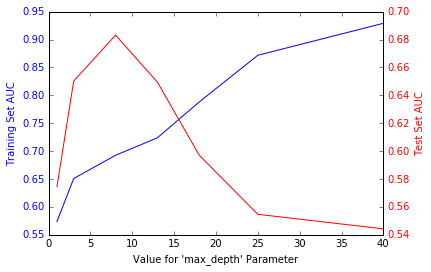

In [23]:
# Don't worry if you don't understand everything that's happening here...
auc_list = list()
train_auc_list = list()
depth_range = [40, 25, 18, 13, 8, 3, 1]

for depth in depth_range:

    mod = tree.DecisionTreeClassifier(random_state=32, max_depth=depth)
    mod.fit(train_X, train_y) # Fit the model

    # Now we can make predictions
    preds = mod.predict_proba(test_X)[:, 1]
    train_preds = mod.predict_proba(train_X)[:, 1]
    
    # Record the performance
    auc_list.append(metrics.roc_auc_score(test_y, preds))
    train_auc_list.append(metrics.roc_auc_score(train_y, train_preds))

# Now let's plot the performance of the models on a dual axis
fig, ax1 = plt.subplots()
ax1.plot(depth_range, train_auc_list, 'b-')
ax1.set_xlabel("Value for 'max_depth' Parameter")
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Training Set AUC', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')


ax2 = ax1.twinx()
ax2.plot(depth_range, auc_list, 'r-')
ax2.set_ylabel('Test Set AUC', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.show()

So as we increase the depth, the training set performance increases to 1. However, this is not true for the all-important test set error.

#### BONUS: Visualising a Decision Tree

As we discussed in the slides, decision trees can also be very insightful when visualised. However, it's very important to 'prune' your tree such that the max_depth is quite small. If you don't prune the depth of the tree, the visualisation can become very large and difficult to follow.

In my opinion, the most insightful trees are *not* the most predictive. So, I often like to visualise a tree with a maximum depth of 3; this may be the one that I show to my clients. However - when it comes to prediction - I may use a deeper tree.

I've created a function generate_dtree_viz() that will generate a .pdf visualisation of a sklearn decision tree. All you need to do is run the two blocks of code below > move the pdf in the path printed out to the notebook to your desktop > open in a PDF reader.

In [24]:
def generate_dtree_viz(clf, filename, column_names=None, path=None):
    """Generate a .pdf visualisation of a decision tree clf and export it to a path"""
    from sklearn.externals.six import StringIO  
    
    if path is None:
        path = os.getcwd()

    # Generate the .dot image
    with open(str(filename) + ".dot", 'w') as f:
         f = tree.export_graphviz(clf, out_file=f, feature_names=column_names)
            
    # Convert the image to a PDF
    subprocess.call("dot -Tpdf " + str(filename) + ".dot -o " + str(filename) + ".pdf", cwd=path, shell=True)
    
    # Tell the user where they can find their file
    print('A .pdf of your decision tree can be found at {0:s}') .format(path + "/" + filename + '.pdf')

In [25]:
clf = tree.DecisionTreeClassifier(random_state=32, max_depth=2)
clf.fit(train_X, train_y) # Fit the model
generate_dtree_viz(clf, 'dtree', train_X.columns)

A .pdf of your decision tree can be found at /nfs/science-tuk-ins/shared/ipythonNotebooks/adamho/AppliedMLTraining/dtree.pdf


##### Q4: Open the PDF of your decision tree. Can you find any interesting insights in your decision tree? Can you think of any interactions that might be useful to generate for your linear model?